In [1]:
%autoawait False

import os, sys
sys.path.append("..")
sys.path.append("../ALAE")
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"  # Limit to 80% of GPU memory
# import ot
# from src.distributions import LoaderSampler, TensorSampler
# from src.ulight_ot import ULightOT
# from tqdm import tqdm
import torch
import torch.nn as t_nn
# import torch.nn.functional as F
# import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

from alae_ffhq_inference import load_model, encode, decode
# from src.plotters import fig2img
from src.fid_score import calculate_frechet_distance
# from src.ulight_ot import ULightOT

import numpy as np
# core jax imports
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, random

# flax is neural-network library
import flax
from flax import linen as nn
# help create state update
from flax.training import train_state

# nnx is another pytorch-like api for flax, which is still in its infancy
# from flax import nnx as nn

# optax is optimization libaray
import optax
import tensorflow as tf

# typing library in python, this library is useful for type-hinting and to make the function inputs/ouputs and class initialization variables to have fixed data type
from typing import Any, Callable, Sequence, Tuple

from functools import partial

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

from flax.training import orbax_utils
from tqdm.notebook import trange
import orbax.checkpoint as ocp
import shutil
import evaluation
import models
import train_utils
import dataloaders


import math


from configs.config_ffhq_embeddings_woman_man import get_config
jax.clear_caches()

2025-09-06 00:34:03.603543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757133243.707047   98870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757133243.739700   98870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/2145/NOT/lib/python3.11/site-packages/diffrax/adjoint.py:414: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can us

In [ ]:
config = get_config()

SEED = 42

torch.manual_seed(SEED)
torch.cuda.empty_cache()

BATCH_SIZE = 10
# BATCH_SIZE = 8

c = 1.0

T_lr = 2e-5
f_lr = 2e-5

max_iter = MAX_STEPS = 50_000
T_STEPS = 1
f_STEPS = 4
EVAL_STEPS = 500
SAVE_STEPS = 500




static_checkpoints =  "/neural-ot-ss/lagrangian-pot-flows/subset_selection_embeddings/code_base/augmented/static_checkpoints/"
ode_checkpoints = "/neural-ot-ss/lagrangian-pot-flows/ss_embeddings_final/code_base/augmented_new/checkpoints/"
one_step_checkpoints = "/neural-ot-ss/lagrangian-pot-flows/ss_embeddings_final/code_base/augmented_new/checkpoints/"

In [3]:
def decode_and_plot(Z, inp_images):
    decoded_img = decode(model, torch.tensor(np.array(Z)))
    decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()

    fig, axes = plt.subplots(number_of_samples+1, latent_to_map.shape[0], figsize=(latent_to_map.shape[0], number_of_samples+1), dpi=200)

    for i, ind in enumerate(range(latent_to_map.shape[0])):
        axes[0, i].imshow(inp_images[ind])
        for k in range(number_of_samples):
            axes[k+1, i].imshow(decoded_img[ind])
            axes[k+1, i].get_xaxis().set_visible(False)
            axes[k+1, i].set_yticks([])
    
        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].set_yticks([])

    fig.tight_layout(pad=0.05)
    
    return fig, axes

model = load_model("../ALAE/configs/ffhq.yaml", training_artifacts_dir="../ALAE/training_artifacts/ffhq/")

/lustre/cniel/neural-ot-ss/lagrangian-pot-flows/ss_embeddings_final/code_base/../ALAE/checkpointer.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

In [ ]:
def sample_t(u0, n, t0=0.0, t1=1.0):
    u = (u0 + math.sqrt(2) * jnp.arange(n + 1)) % 1  # Generate n+1 samples and apply modulo 1
    u = u.reshape([-1, 1])                           # Reshape u to a column vector
    return u[:-1] * (t1 - t0) + t0, u[-1]


def evaluate_qnet(key, config, model_q, params_q, dataset, time=1):
    input_shape = (jax.device_count(), config.data.batch_size//jax.device_count(), config.data.dim)

    data_set_name = config.data.target
    
    if config.data.target in ["ffhq_MAN", "ffhq_WOMAN", "ffhq_ADULT", "ffhq_YOUNG"]:  
        DEVICE = 'cpu'
          
        gen_outputs = []
        sexes = [] 
        ages = []
        for x0, sex, age in dataset:
            x0 = jnp.reshape(x0.numpy(), input_shape)
            u0 = jax.random.uniform(key, 1)
            t, _ = sample_t(u0, batch[0].shape[0])
            outputs = model_q.apply(params_q, t, x0, x0)
            gen_outputs.append(outputs.reshape(-1,config.data.dim))
            sexes.append(sex.numpy().reshape(-1,))
            ages.append(age.numpy().reshape(-1,))
            
        gen_outputs_ = np.vstack(gen_outputs)
        sexes = np.hstack(sexes)
        ages = np.hstack(ages)
            
        if data_set_name in ["ffhq_ADULT", "ffhq_YOUNG"]:
            mlp_classifier = BinaryClassifier()
            mlp_classifier.load_state_dict(torch.load('/neural-ot-ss/lagrangian-pot-flows/subset_selection_embeddings/classifier_checkpoints/male_female_classifier.pth', map_location=DEVICE, weights_only=True))
            
            target_mlp_classifier = BinaryClassifier()
            target_mlp_classifier.load_state_dict(torch.load('/neural-ot-ss/lagrangian-pot-flows/subset_selection_embeddings/classifier_checkpoints/young_old_classifier.pth', map_location=DEVICE, weights_only=True))
        
        elif data_set_name in ['ffhq_MAN', 'ffhq_WOMAN']:
            mlp_classifier = BinaryClassifier()
            mlp_classifier.load_state_dict(torch.load('/neural-ot-ss/lagrangian-pot-flows/subset_selection_embeddings/classifier_checkpoints/young_old_classifier.pth', map_location=DEVICE, weights_only=True))
    
            target_mlp_classifier = BinaryClassifier()
            target_mlp_classifier.load_state_dict(torch.load('/neural-ot-ss/lagrangian-pot-flows/subset_selection_embeddings/classifier_checkpoints/male_female_classifier.pth', map_location=DEVICE, weights_only=True))
        
        return evaluate_ffhq(config, gen_outputs_, sexes, ages, mlp_classifier, target_mlp_classifier)

In [38]:
# source = "YOUNG"  # MAN, WOMAN, ADULT, YOUNG
# target = "ADULT"  # MAN, WOMAN, ADULT, YOUNG

# source = "ADULT"  # MAN, WOMAN, ADULT, YOUNG
# target = "YOUNG"  # MAN, WOMAN, ADULT, YOUNG

# source = "MAN"  # MAN, WOMAN, ADULT, YOUNG
# target = "WOMAN"  # MAN, WOMAN, ADULT, YOUNG

source = "WOMAN"  # MAN, WOMAN, ADULT, YOUNG
target = "MAN"  # MAN, WOMAN, ADULT, YOUNG


INPUT_DATA = source
TARGET_DATA = target 
cs = [1.0, 2.0, 4.0, 8.0]


# if source == "WOMAN" and target == "MAN":
#     ckpts = [43000,	48000,	43000,	31000]
# if source == "MAN" and target == "WOMAN":
#     ckpts = [41000,	49000,	42000,	42000]
# if source == "YOUNG" and target == "ADULT":
#     ckpts = [43000,	46000,	36000,	47000]
# if source == "ADULT" and target == "YOUNG":
#     ckpts = [41000,	30000,	26000,	29000]

if source == "WOMAN" and target == "MAN":
    ckpts = [500_000, 500_000, 500_000,	500_000]
if source == "MAN" and target == "WOMAN":
    ckpts = [500_000, 500_000, 500_000,	500_000]
if source == "YOUNG" and target == "ADULT":
    ckpts = [500_000, 500_000, 500_000,	500_000]
if source == "ADULT" and target == "YOUNG":
    ckpts = [500_000, 500_000, 500_000,	500_000]



# To download data use
train_size = 60000
test_size = 10000

latents = np.load("../data/latents.npy")
gender = np.load("../data/gender.npy")
age = np.load("../data/age.npy")
test_inp_images = np.load("../data/test_images.npy")

train_latents, test_latents = latents[:train_size], latents[train_size:]
train_gender, test_gender = gender[:train_size], gender[train_size:]
train_age, test_age = age[:train_size], age[train_size:]
    
if INPUT_DATA == "MAN":
    x_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif INPUT_DATA == "WOMAN":
    x_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    x_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif INPUT_DATA == "ADULT":
    x_inds_train = np.arange(train_size)[
        (train_age > 44).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        (test_age > 44).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif INPUT_DATA == "YOUNG":
    x_inds_train = np.arange(train_size)[
        ((train_age > 16) & (train_age <= 44)).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    x_inds_test = np.arange(test_size)[
        ((test_age > 16) & (test_age <= 44)).reshape(-1)*(test_age != -1).reshape(-1)
    ]

if TARGET_DATA == "MAN":
    y_inds_train = np.arange(train_size)[(train_gender == "male").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "male").reshape(-1)]
elif TARGET_DATA == "WOMAN":
    y_inds_train = np.arange(train_size)[(train_gender == "female").reshape(-1)]
    y_inds_test = np.arange(test_size)[(test_gender == "female").reshape(-1)]
elif TARGET_DATA == "ADULT":
    y_inds_train = np.arange(train_size)[
        (train_age > 44).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        (test_age > 44).reshape(-1)*(test_age != -1).reshape(-1)
    ]
elif TARGET_DATA == "ADULT-MAN":
    male_train = np.arange(train_size)[(train_gender == "male")]
    male_test = np.arange(test_size)[(test_gender == "male")]
    
    y_inds_train = male_train[(train_age[male_train].reshape(-1) > 44)]#*(train_age != -1)
    y_inds_test = male_test[(test_age[male_test].reshape(-1) > 44)]#*(test_age != -1).reshape(-1)
elif TARGET_DATA == "YOUNG":
    y_inds_train = np.arange(train_size)[
        ((train_age > 16) & (train_age <= 44)).reshape(-1)*(train_age != -1).reshape(-1)
    ]
    y_inds_test = np.arange(test_size)[
        ((test_age > 16) & (test_age <= 44)).reshape(-1)*(test_age != -1).reshape(-1)
    ]  
    
x_data_train = train_latents[x_inds_train]
x_data_test = test_latents[x_inds_test]
x_data_test_gender = test_gender[x_inds_test]
x_data_test_age = test_age[x_inds_test]

inds_to_map = np.random.choice(np.arange((x_inds_test < 300).sum()), size=BATCH_SIZE, replace=False)
number_of_samples = 1
mapped_all = []
latent_to_map = torch.tensor(test_latents[x_inds_test[inds_to_map]])
inp_images = test_inp_images[x_inds_test[inds_to_map]]
    
y_data_train = train_latents[y_inds_train]
y_data_test = test_latents[y_inds_test]


In [39]:
Z_ode_list = []
Z_one_list = []
Z_q_list = []

for k in range(0, len(cs)):
    c = cs[k]
    step = ckpts[k]
    path = os.path.join(ode_checkpoints, "ffhq_"+source+"_ffhq_" + target, str(c))
    seed = 0
    np.random.seed(seed)
    key = random.PRNGKey(seed)
    DS = 4000
    key, loc_key = random.split(key)
    
    DIM = 512
    BS = latent_to_map.shape[0]
    
    mu = np.mean(y_data_test)
    cov = np.cov(y_data_test, rowvar=False)
    
    seed = 0
    ##############################
    gamma = 1.0
    c_iters = 0
    ##############################
    wf_lr = 1e-2
    # wf_lr = 1e-1
    # key = random.PRNGKey(0)
    key, *init_keys = random.split(key, 3)
    
    # Specify the clipping threshold
    clip_value = 10.0 # we do not use it in our implementation
    
    model_s = models.Smodel(config.model_s.num_hid, config.model_s.num_out, config.model_s.t_embed_dim)
    model_s_eval = models.Smodel_eval(config.model_s.num_hid, config.model_s.num_out, config.model_s.t_embed_dim)
    model_q = models.Qmodel(config.model_q.num_hid, config.model_q.num_out, config.model_s.t_embed_dim)
    
    optimizer_s = train_utils.get_optimizer(config.optimizer_s)
    optimizer_q = train_utils.get_optimizer(config.optimizer_q)
    
    BS = 10
    DIM =  512
    
    init_params_s = model_s.init(init_keys[0], np.ones([BS,1]), np.ones([BS, DIM]))
    init_params_q = model_q.init(init_keys[1], np.ones([BS,1]), np.ones([BS, DIM]),np.ones([BS, DIM]))
    
    opt_state_s = optimizer_s.init(init_params_s)
    opt_state_q = optimizer_q.init(init_params_q)
    
    state_s = models.State(step=0, opt_state=opt_state_s, model_params=init_params_s, ema_rate=config.model_s.ema_rate, params_ema=init_params_s, c=config.c, key=key)
    state_q = models.State(step=0, opt_state=opt_state_q, model_params=init_params_q, ema_rate=config.model_q.ema_rate, params_ema=init_params_q, c=config.c, key=key)
    
    options = ocp.CheckpointManagerOptions(max_to_keep=10000)
    ckpt_mgr = ocp.CheckpointManager(path, options=options, item_names={"state_s", "state_q"})
    state = ckpt_mgr.restore(step, args=ocp.args.Composite(state_s=ocp.args.StandardRestore(state_s),state_q=ocp.args.StandardRestore(state_q))).state_s
    
    
    g_one = evaluation.get_generator_one_step(model_s_eval)
    g_ode = evaluation.get_generator_one_step(model_s_eval)
    
    Z_ode_list.append(g_ode(latent_to_map.numpy(), state))
    Z_one_list.append(g_ode(latent_to_map.numpy(), state))


(10, 128)
(10, 128)
(10, 128)
(10, 128)


In [40]:
# latent_to_map

In [41]:
def decode_and_plot(Z, inp_images, cs=[1,2,4,8]):
    g_img = []
    for k in range(0, len(Z)):
        decoded_img = decode(model, torch.tensor(np.array(Z[k])))
        decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        g_img.append(decoded_img)

    fig, axes = plt.subplots(len(Z)+1, latent_to_map.shape[0], figsize=(latent_to_map.shape[0]-2, 1*len(Z)), dpi=200,  gridspec_kw={'wspace': 0, 'hspace': 0})

    for i, ind in enumerate(range(latent_to_map.shape[0])):
        axes[0, i].imshow(inp_images[ind])
        ylabel_str = "source"
        axes[0, 0].set_ylabel(ylabel_str, rotation='vertical', ha='right', fontsize=12)
        axes[0, 0].yaxis.set_label_coords(-0.0, 0.85)
        for k in range(len(Z)):
            axes[k+1, i].imshow(g_img[k][ind])
            axes[k+1, i].get_xaxis().set_visible(False)
            axes[k+1, i].set_yticks([])
            ylabel_str = str("c={:d}".format(cs[k]))
            axes[k+1, 0].set_ylabel(ylabel_str, rotation='vertical', ha='right', fontsize=12)
            axes[k+1, 0].yaxis.set_label_coords(-0.0, 0.70)

        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].set_yticks([])

         # Rotate text vertically
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    fig.tight_layout(pad=0, h_pad=0, w_pad=0)  # Force remove padding
    plt.show()

    fig.tight_layout(pad=0.05)
    
    return fig, axes

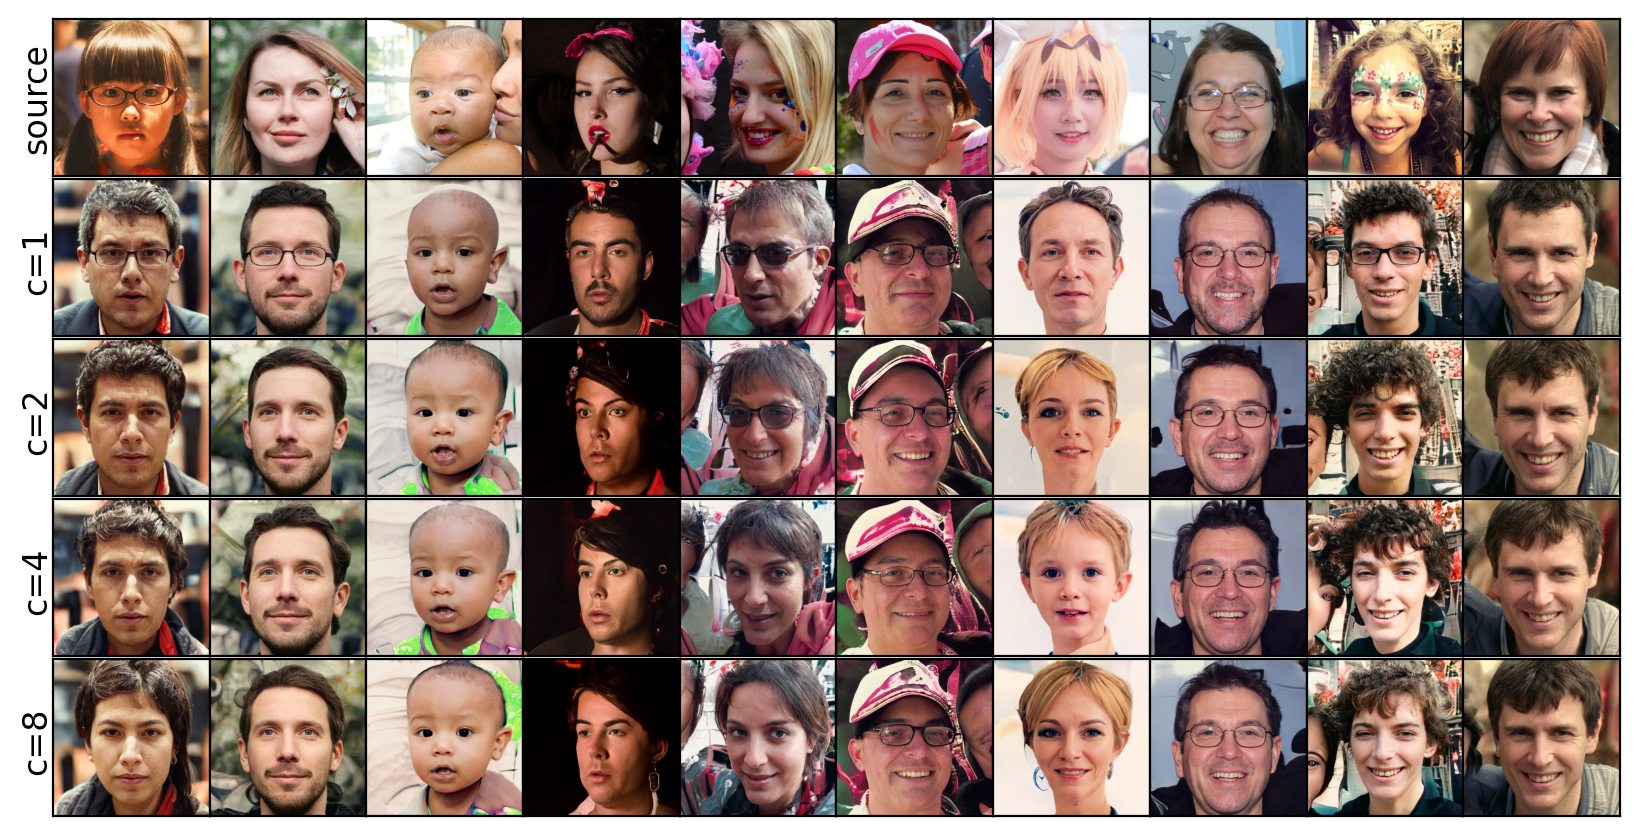

In [42]:
Z_all = np.stack(Z_ode_list)
fig, axs = decode_and_plot(Z_all, inp_images)
%matplotlib inline
plt.show()
fig_name = source + "_" + target + "_dynamic_"
fig.savefig(fig_name + "ode" + ".png", format="png")

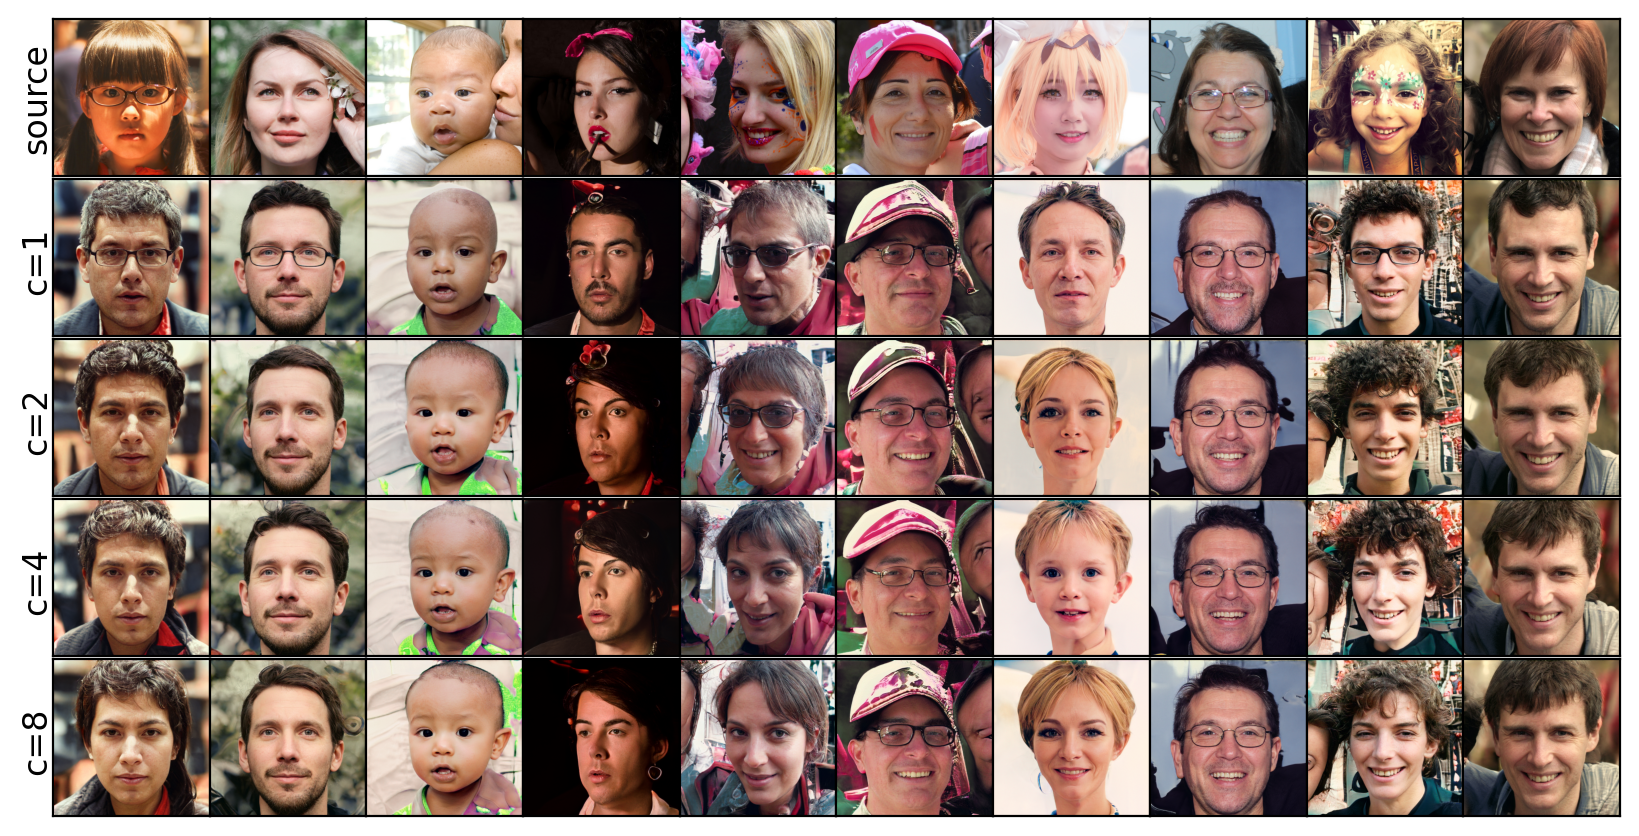

In [43]:
Z_all = np.stack(Z_one_list)
fig, axs = decode_and_plot(Z_all, inp_images)
%matplotlib inline
plt.show()
fig_name = source + "_" + target  + "_dynamic_"
fig.savefig(fig_name + "one_step" + ".png", format="png")

In [44]:
#STATIC

In [45]:
import os, sys
sys.path.append("..")
sys.path.append("../ALAE")

import torch
import numpy as np
import ot

from src.distributions import LoaderSampler, TensorSampler
from src.ulight_ot import ULightOT
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.optim.swa_utils import AveragedModel, update_bn

import wandb
import matplotlib
from matplotlib import pyplot as plt
# from torch.optim.lr_scheduler import MultiStepLR
from IPython.display import clear_output
from torch.optim.swa_utils import AveragedModel, update_bn, get_ema_multi_avg_fn


# from ALAE.alae_ffhq_inference import load_model, encode, decode


if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

num_gpus = torch.cuda.device_count()

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.nn import Parameter
# import torch.optim.lr_scheduler as lr_scheduler
# import torchvision.transforms as transforms



from absl import app
from absl import flags
from ml_collections.config_flags import config_flags

from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

from alae_ffhq_inference import load_model, encode, decode
# from src.plotters import fig2img
from src.fid_score import calculate_frechet_distance

In [46]:
class TransportNET(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TransportNET, self).__init__()
        self.MLP = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.SiLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.SiLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.SiLU(),
                                 nn.Linear(hidden_dim, input_dim))
        self.ResConnect = nn.Linear(input_dim, input_dim)

    def forward(self, inputs):
        output = self.MLP(inputs) + self.ResConnect(inputs)
        return output

In [47]:
Z_static = []

# if source == "WOMAN" and target == "MAN":
#     s_ckpts = [50000,	50000,	50000,	50000]
# if source == "MAN" and target == "WOMAN":
#     s_ckpts = [50000,	50000,	50000,	50000]
# if source == "YOUNG" and target == "ADULT":
#     s_ckpts = [3000,	49000,	50000,	50000]
# if source == "ADULT" and target == "YOUNG":
#     s_ckpts = [48000,	35000,	34000,	50000]

if source == "WOMAN" and target == "MAN":
    s_ckpts = [50000,	50000,	50000,	50000]
if source == "MAN" and target == "WOMAN":
    s_ckpts = [50000,	50000,	50000,	50000]
if source == "YOUNG" and target == "ADULT":
    s_ckpts = [50000,	50000,	50000,	50000]
if source == "ADULT" and target == "YOUNG":
    s_ckpts = [50000,	50000,	50000,	50000]


for k in range(0, len(cs)):
    c = cs[k]
    step = ckpts[k]
    path = os.path.join(static_checkpoints + 'ffhq_'+ source +"_"+target, 'c={}'.format(c), "checkpoint_"+str(s_ckpts[k])+".pth")
    seed = 0
    np.random.seed(seed)
    key = random.PRNGKey(seed)
    DS = 4000
    key, loc_key = random.split(key)
    
    DIM = 512
    BS = latent_to_map.shape[0]
    
    netT = TransportNET(512, 1024).to(device)
    netT.load_state_dict(torch.load(path, weights_only=True)['netT_dict'])
    netT.eval()

    Z_static.append(netT(latent_to_map.to(device)).detach().cpu().numpy())


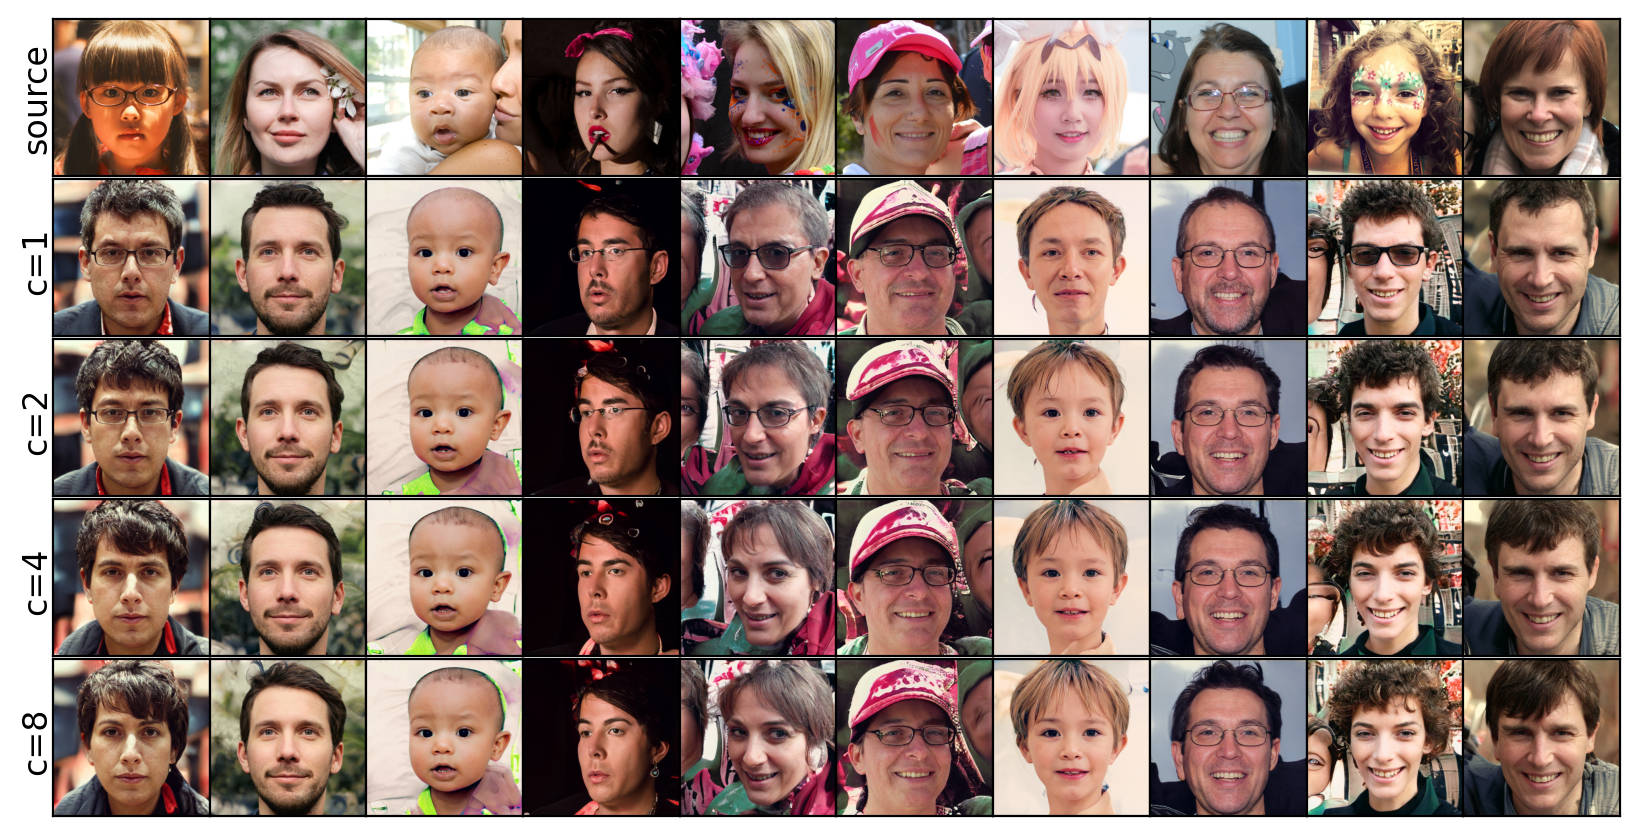

In [48]:
Z_all = np.stack(Z_static)
fig, axs = decode_and_plot(Z_all, inp_images)
%matplotlib inline
plt.show()
fig_name = source + "_" + target  
fig.savefig(fig_name + "_static" + ".png", format="png")